# McKinney Chapter 11 - Time Series

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Introduction

Chapter 11 of @mckinney2022python discusses time series and panel data, which is where pandas *excels!*
We will use these time series and panel tools every day for the rest of the course.

We will focus on:

1. Slicing a data frame or series by date or date range
1. Using `.shift()` to create leads and lags of variables
1. Using `.resample()` to change the frequency of variables
1. Using `.rolling()` to aggregate data over moving or rolling windows

***Note:*** 
Indented block quotes are from @mckinney2022python unless otherwise indicated. 
The section numbers here differ from @mckinney2022python because we will only discuss some topics.

## Time Series Basics

Let us create a time series to play with.

In [3]:
from datetime import datetime
dates = [
    datetime(2011, 1, 2), 
    datetime(2011, 1, 5),
    datetime(2011, 1, 7), 
    datetime(2011, 1, 8),
    datetime(2011, 1, 10), 
    datetime(2011, 1, 12)
]
np.random.seed(42)
ts = pd.Series(np.random.randn(6), index=dates)

ts

2011-01-02    0.4967
2011-01-05   -0.1383
2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
2011-01-12   -0.2341
dtype: float64

Note that pandas converts the `datetime` objects to a pandas `DatetimeIndex` object and a single index value is a `Timestamp` object.

In [4]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

In [5]:
ts.index[0]

Timestamp('2011-01-02 00:00:00')

Recall that pandas automatically aligns objects on indexes.

In [6]:
ts

2011-01-02    0.4967
2011-01-05   -0.1383
2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
2011-01-12   -0.2341
dtype: float64

In [7]:
ts.iloc[::2]

2011-01-02    0.4967
2011-01-07    0.6477
2011-01-10   -0.2342
dtype: float64

In [8]:
ts + ts.iloc[::2]

2011-01-02    0.9934
2011-01-05       NaN
2011-01-07    1.2954
2011-01-08       NaN
2011-01-10   -0.4683
2011-01-12       NaN
dtype: float64

If we want to assign a default for missing values on the fly, we can use the `.add()` method.

In [9]:
ts.add(ts.iloc[::2], fill_value=1_000_000)

2011-01-02         0.9934
2011-01-05    999999.8617
2011-01-07         1.2954
2011-01-08   1000001.5230
2011-01-10        -0.4683
2011-01-12    999999.7659
dtype: float64

### Indexing, Selection, Subsetting

pandas uses U.S.-style date strings (e.g., "M/D/Y") or unambiguous date strings (e.g., "YYYY-MM-DD") to select data.

In [10]:
ts.loc['1/10/2011'] # M/D/YYYY

-0.2342

In [11]:
ts.loc['2011-01-10'] # YYYY-MM-DD

-0.2342

In [12]:
ts.loc['20110110'] # YYYYMMDD

-0.2342

In [13]:
ts.loc['10-Jan-2011'] # D-Mon-YYYY

-0.2342

In [14]:
ts.loc['Jan-10-2011'] # Mon-D-YYYY

-0.2342

pandas *does not* use U.K.-style date strings.

In [15]:
# ts.loc['10/1/2011'] # D/M/YYYY # KeyError: '10/1/2011'

Let us create a *longer* time series to play with.

In [16]:
np.random.seed(42)
longer_ts = pd.Series(
    data=np.random.randn(1000),
    index=pd.date_range('1/1/2000', periods=1000)
)

In [17]:
longer_ts

2000-01-01    0.4967
2000-01-02   -0.1383
2000-01-03    0.6477
2000-01-04    1.5230
2000-01-05   -0.2342
               ...  
2002-09-22   -0.2811
2002-09-23    1.7977
2002-09-24    0.6408
2002-09-25   -0.5712
2002-09-26    0.5726
Freq: D, Length: 1000, dtype: float64

We can specify a year-month to slice all of the observations in May of 2001.

In [18]:
longer_ts.loc['2001-05']

2001-05-01   -0.6466
2001-05-02   -1.0815
2001-05-03    1.6871
2001-05-04    0.8816
2001-05-05   -0.0080
2001-05-06    1.4799
2001-05-07    0.0774
2001-05-08   -0.8613
2001-05-09    1.5231
2001-05-10    0.5389
2001-05-11   -1.0372
2001-05-12   -0.1903
2001-05-13   -0.8756
2001-05-14   -1.3828
2001-05-15    0.9262
2001-05-16    1.9094
2001-05-17   -1.3986
2001-05-18    0.5630
2001-05-19   -0.6506
2001-05-20   -0.4871
2001-05-21   -0.5924
2001-05-22   -0.8640
2001-05-23    0.0485
2001-05-24   -0.8310
2001-05-25    0.2705
2001-05-26   -0.0502
2001-05-27   -0.2389
2001-05-28   -0.9076
2001-05-29   -0.5768
2001-05-30    0.7554
2001-05-31    0.5009
Freq: D, dtype: float64

We can also specify a year to slice all observations in 2001.

In [19]:
longer_ts.loc['2001']

2001-01-01    0.2241
2001-01-02    0.0126
2001-01-03    0.0977
2001-01-04   -0.7730
2001-01-05    0.0245
               ...  
2001-12-27    0.0184
2001-12-28    0.3476
2001-12-29   -0.5398
2001-12-30   -0.7783
2001-12-31    0.1958
Freq: D, Length: 365, dtype: float64

If we sort our data chronologically, we can also slice with a range of date strings.

In [20]:
ts.loc['1/6/2011':'1/10/2011']

2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
dtype: float64

However, we cannot date slice if our data are not sorted chronologically.

In [21]:
ts2 = ts.sort_values()

In [22]:
ts2

2011-01-10   -0.2342
2011-01-12   -0.2341
2011-01-05   -0.1383
2011-01-02    0.4967
2011-01-07    0.6477
2011-01-08    1.5230
dtype: float64

The following date slice fails because `ts2` is not sorted chronologically.

In [23]:
# ts2.loc['1/6/2011':'1/11/2011'] # KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

We can use the `.sort_index()` method first to allow date slices.

In [24]:
ts2.sort_index()['1/6/2011':'1/11/2011']

2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
dtype: float64

*As with label slices, date slices are inclusive on both ends.*

In [25]:
longer_ts.loc['1/6/2001':'1/11/2001']

2001-01-06    0.4980
2001-01-07    1.4511
2001-01-08    0.9593
2001-01-09    2.1532
2001-01-10   -0.7673
2001-01-11    0.8723
Freq: D, dtype: float64

*Recall that if we modify a slice, we modify the original series or data frame.*

> Remember that slicing in this manner produces views on the source time series like slicing NumPy arrays. This means that no data is copied and modifications on the slice will be reflected in the original data.

In [26]:
ts3 = ts.copy()

In [27]:
ts3

2011-01-02    0.4967
2011-01-05   -0.1383
2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
2011-01-12   -0.2341
dtype: float64

In [28]:
ts4 = ts3.iloc[:3]

In [29]:
ts4

2011-01-02    0.4967
2011-01-05   -0.1383
2011-01-07    0.6477
dtype: float64

In [30]:
ts4.iloc[:] = 2001

In [31]:
ts4

2011-01-02   2001.0000
2011-01-05   2001.0000
2011-01-07   2001.0000
dtype: float64

In [32]:
ts3

2011-01-02   2001.0000
2011-01-05   2001.0000
2011-01-07   2001.0000
2011-01-08      1.5230
2011-01-10     -0.2342
2011-01-12     -0.2341
dtype: float64

Series `ts` is unchanged because `ts3` is a *copy* of `ts`!

In [33]:
ts

2011-01-02    0.4967
2011-01-05   -0.1383
2011-01-07    0.6477
2011-01-08    1.5230
2011-01-10   -0.2342
2011-01-12   -0.2341
dtype: float64

### Time Series with Duplicate Indices

Most our of data in this course will be well-formed with one observation per date-time for series or one observation per individual per date-time for data frames.
However, we may later receive poorly-formed data with duplicate observations.
Here, series `dup_ts` has three observations on February 2nd.

In [34]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000', '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(data=np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int64

The `.is_unique` attribute tells us if an index is unique.

In [35]:
dup_ts.index.is_unique

False

In [36]:
dup_ts.loc['1/3/2000'] # not duplicated

np.int64(4)

In [37]:
dup_ts.loc['1/2/2000'] # duplicated

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int64

The solution to duplicate data depends on the context.
For example, we may want the mean of all observations on a given date.
The `.groupby()`  method can help us here.

In [38]:
dup_ts.groupby(level=0).mean()

2000-01-01   0.0000
2000-01-02   2.0000
2000-01-03   4.0000
dtype: float64

In [39]:
dup_ts.groupby(level=0).first()

2000-01-01    0
2000-01-02    1
2000-01-03    4
dtype: int64

## Date Ranges, Frequencies, and Shifting

> Generic time series in pandas are assumed to be irregular; that is, they have no fixed frequency. For many applications this is sufficient. However, it’s often desirable to work relative to a fixed frequency, such as daily, monthly, or every 15 minutes, even if that means introducing missing values into a time series. Fortunately pandas has a full suite of standard time series frequencies and tools for resampling, inferring frequencies, and generating fixed-frequency date ranges.

### Shifting Data

*Shifting is an important feature!*
Shifting is moving data backward (or forward) through time.

In [40]:
np.random.seed(42)
ts = pd.Series(
    data=np.random.randn(4),
    index=pd.date_range('1/1/2000', periods=4, freq='ME')
)

In [41]:
ts

2000-01-31    0.4967
2000-02-29   -0.1383
2000-03-31    0.6477
2000-04-30    1.5230
Freq: ME, dtype: float64

If we specify a *positive integer* $N$ to the `.shift()` method:

1. The date index remains the same
2. Values *shift down* $N$ observations

The `.shift()` method defaults to $N=1$.

In [42]:
ts.shift()

2000-01-31       NaN
2000-02-29    0.4967
2000-03-31   -0.1383
2000-04-30    0.6477
Freq: ME, dtype: float64

In [43]:
ts.shift(1)

2000-01-31       NaN
2000-02-29    0.4967
2000-03-31   -0.1383
2000-04-30    0.6477
Freq: ME, dtype: float64

In [44]:
ts.shift(2)

2000-01-31       NaN
2000-02-29       NaN
2000-03-31    0.4967
2000-04-30   -0.1383
Freq: ME, dtype: float64

If we specify a *negative integer* $N$ to the `.shift()` method, values *shift up* $N$ observations.

In [45]:
ts.shift(-2)

2000-01-31   0.6477
2000-02-29   1.5230
2000-03-31      NaN
2000-04-30      NaN
Freq: ME, dtype: float64

::: {.callout-note}

We almost never shift with negative values to prevent a look-ahead bias.
That is, assuming chronological sorting, we almost never bring values from the future back to the present.
We do not want to assume that financial market participants know the future.

:::

The `.shift()` examples above shift by $N$ observations without considering time stamps.
As a result, the time stamps are unchanged, and values shift down for positive `periods` or up for negative `periods`.
However, we can specify the `freq` argument to consider time stamps.
With the `freq` argument, time stamps shift by `periods` multiples of the  `freq` argument.

In [46]:
ts

2000-01-31    0.4967
2000-02-29   -0.1383
2000-03-31    0.6477
2000-04-30    1.5230
Freq: ME, dtype: float64

In [47]:
ts.shift(periods=2, freq='ME')

2000-03-31    0.4967
2000-04-30   -0.1383
2000-05-31    0.6477
2000-06-30    1.5230
Freq: ME, dtype: float64

In [48]:
ts.shift(periods=3, freq='D')

2000-02-03    0.4967
2000-03-03   -0.1383
2000-04-03    0.6477
2000-05-03    1.5230
dtype: float64

`M` is already months, so `min` is minutes.

In [49]:
ts.shift(periods=1, freq='90min')

2000-01-31 01:30:00    0.4967
2000-02-29 01:30:00   -0.1383
2000-03-31 01:30:00    0.6477
2000-04-30 01:30:00    1.5230
dtype: float64

### Calculating returns

We can calculate returns in two ways.
First, easily with the `.pct_change()` method.

In [50]:
ts.pct_change()

2000-01-31       NaN
2000-02-29   -1.2784
2000-03-31   -5.6844
2000-04-30    1.3515
Freq: ME, dtype: float64

Second, manaully with the `.shift()` method.

In [51]:
(ts - ts.shift()) / ts.shift()

2000-01-31       NaN
2000-02-29   -1.2784
2000-03-31   -5.6844
2000-04-30    1.3515
Freq: ME, dtype: float64

These two return calculations are the same.

In [52]:
np.allclose(
    a=ts.pct_change(),
    b=(ts - ts.shift()) / ts.shift(),
    equal_nan=True
)

True

Two observations on these return calculations:

1. The first percent change is `NaN` because there is no previous value to change from
2. The default for `.shift()`  and `.pct_change()` is `periods=1`

### Shifting dates with offsets

We can also shift time stamps to the beginning or end of a period.

In [53]:
from pandas.tseries.offsets import MonthEnd
now = datetime(2011, 11, 17)

In [54]:
now

datetime.datetime(2011, 11, 17, 0, 0)

`MonthEnd(0)` moves to the end of the month *but does not leave the current month.*

In [55]:
now + MonthEnd(0)

Timestamp('2011-11-30 00:00:00')

`MonthEnd(1)` moves to the end of the *current* month.
If already at the end of the *current* month, it moves to the end of the *next* month.

In [56]:
now + MonthEnd(1)

Timestamp('2011-11-30 00:00:00')

In [57]:
now + MonthEnd(1) + MonthEnd(1)

Timestamp('2011-12-31 00:00:00')

In [58]:
now + MonthEnd(0) + MonthEnd(1)

Timestamp('2011-12-31 00:00:00')

***Be careful! The `MonthEnd()` default is `n=1`!***

In [59]:
datetime(2021, 10, 31) + MonthEnd(0)

Timestamp('2021-10-31 00:00:00')

In [60]:
datetime(2021, 10, 31) + MonthEnd(1)

Timestamp('2021-11-30 00:00:00')

In [61]:
datetime(2021, 10, 31) + MonthEnd()

Timestamp('2021-11-30 00:00:00')

***Always check your output!***

## Resampling and Frequency Conversion

*Resampling is an important feature!*

> Resampling refers to the process of converting a time series from one frequency to
another. Aggregating higher frequency data to lower frequency is called 
downsampling, while converting lower frequency to higher frequency is called upsampling. Not
all resampling falls into either of these categories; for example, converting W-WED
(weekly on Wednesday) to W-FRI is neither upsampling nor downsampling.

We can resample both series and data frames.
The `.resample()` method syntax is similar to `.groupby()`.

### Downsampling

> Aggregating data to a regular, lower frequency is a pretty normal time series task. The
data you’re aggregating doesn’t need to be fixed frequently; the desired frequency
defines bin edges that are used to slice the time series into pieces to aggregate. For
example, to convert to monthly, 'M' or 'BM', you need to chop up the data into 
one-month intervals. Each interval is said to be half-open; a data point can only belong to
one interval, and the union of the intervals must make up the whole time frame.
There are a couple things to think about when using resample to downsample data:
>
> - Which side of each interval is closed
> - How to label each aggregated bin, either with the start of the interval or the end

In [62]:
rng = pd.date_range(start='2000-01-01', periods=12, freq='min')
ts = pd.Series(np.arange(12), index=rng)

In [63]:
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: min, dtype: int64

We can aggregate the one-minute frequency data above to five-minute frequency data.
Resampling requires an aggregation method.
Here, we use the `.sum()` method.

In [64]:
ts.resample('5min').sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5min, dtype: int64

When we resample with a minute-frequency:

1. Left edges of the resampling interval are closed (included) and right edges are open (excluded)
2. Labels are by the left edge of the resampling interval by default

In the example above, the first value of 10 at midnight is the sum of values at midnight until 00:05, excluding the value at 00:05.
That is, the sums are $10 = 0+1+2+3+4$ at 00:00, $35 = 5+6+7+8+9$ at 00:05, and so on.
We can use the `closed` and `label` arguments to change this behavior.

In finance, we generally prefer `closed='right'` and `label='right'` to avoid a lookahead bias.

In [65]:
ts.resample('5min', closed='right', label='right').sum() 

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5min, dtype: int64

These defaults for minute-frequency data may seem odd, but any choice is arbitrary.
The defaults for weekly and lower frequencies are `closed='right'` and `label='right'`, which are corect for finance.
Still, we should read the docstring and check our output whenever we use the `.resample()` method!

### Upsampling and Interpolation

To downsample (i.e., resample from higher to lower frequency), we must aggregate (e.g., `.mean()`, `.sum()`, `.first()`, or `.last()`).
To upsample (i.e., resample from lower to higher frequency), we must choose how to fill in the new, higher-frequency observations.

In [66]:
np.random.seed(42)
frame = pd.DataFrame(
    data=np.random.randn(2, 4),
    index=pd.date_range('1/1/2000', periods=2, freq='W-WED'),
    columns=['Colorado', 'Texas', 'New York', 'Ohio']
)

In [67]:
frame

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


We use the `.asfreq()` method to convert to the new frequency and leave the new observations as missing.

In [68]:
df_daily = frame.resample('D').asfreq()

In [69]:
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


We use the `.ffill()` method to forward fill values to replace missing values.

In [70]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-06,0.4967,-0.1383,0.6477,1.5230
2000-01-07,0.4967,-0.1383,0.6477,1.5230
2000-01-08,0.4967,-0.1383,0.6477,1.5230
2000-01-09,0.4967,-0.1383,0.6477,1.5230
2000-01-10,0.4967,-0.1383,0.6477,1.5230
2000-01-11,0.4967,-0.1383,0.6477,1.5230
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


In [71]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,0.4967,-0.1383,0.6477,1.5230
2000-01-06,0.4967,-0.1383,0.6477,1.5230
2000-01-07,0.4967,-0.1383,0.6477,1.5230
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.2342,-0.2341,1.5792,0.7674


In [72]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,0.4967,-0.1383,0.6477,1.5230
2000-01-13,-0.2342,-0.2341,1.5792,0.7674


## Moving Window Functions

*Moving or rolling window functions are one of the neatest features of pandas.!*

In [73]:
df = (
    yf.download(
        tickers=['AAPL', 'MSFT', 'SPY'],
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
)

In [74]:
df

Price      Adj Close                      Close                       High  \
Ticker          AAPL     MSFT      SPY     AAPL     MSFT      SPY     AAPL   
Date                                                                         
1980-12-12    0.0987      NaN      NaN   0.1283      NaN      NaN   0.1289   
1980-12-15    0.0936      NaN      NaN   0.1217      NaN      NaN   0.1222   
1980-12-16    0.0867      NaN      NaN   0.1127      NaN      NaN   0.1133   
1980-12-17    0.0889      NaN      NaN   0.1155      NaN      NaN   0.1161   
1980-12-18    0.0914      NaN      NaN   0.1189      NaN      NaN   0.1194   
...              ...      ...      ...      ...      ...      ...      ...   
2025-02-21  245.5500 408.2100 599.9400 245.5500 408.2100 599.9400 248.6900   
2025-02-24  247.1000 404.0000 597.2100 247.1000 404.0000 597.2100 248.8600   
2025-02-25  247.0400 397.9000 594.2400 247.0400 397.9000 594.2400 250.0000   
2025-02-26  240.3600 399.7300 594.5400 240.3600 399.7300 594.5400 244.9800   
2025-02-27  237.3000 392.5300 585.0500 237.3000 392.5300 585.0500 242.4600   

Price                             Low                       Open           \
Ticker         MSFT      SPY     AAPL     MSFT      SPY     AAPL     MSFT   
Date                                                                        
1980-12-12      NaN      NaN   0.1283      NaN      NaN   0.1283      NaN   
1980-12-15      NaN      NaN   0.1217      NaN      NaN   0.1222      NaN   
1980-12-16      NaN      NaN   0.1127      NaN      NaN   0.1133      NaN   
1980-12-17      NaN      NaN   0.1155      NaN      NaN   0.1155      NaN   
1980-12-18      NaN      NaN   0.1189      NaN      NaN   0.1189      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
2025-02-21 418.0500 610.3000 245.2200 407.8900 599.4700 245.9500 417.3400   
2025-02-24 409.3700 603.0300 244.4200 399.3200 596.4900 244.9300 408.5100   
2025-02-25 401.9200 597.8900 244.9100 396.7000 589.5600 248.0000 401.1000   
2025-02-26 403.6000 599.5800 239.1300 394.2500 591.8600 244.3300 398.0100   
2025-02-27 405.7400 598.0200 237.0600 392.1700 584.6500 239.4100 401.2700   

Price                   Volume                              
Ticker          SPY       AAPL          MSFT           SPY  
Date                                                        
1980-12-12      NaN  469033600           NaN           NaN  
1980-12-15      NaN  175884800           NaN           NaN  
1980-12-16      NaN  105728000           NaN           NaN  
1980-12-17      NaN   86441600           NaN           NaN  
1980-12-18      NaN   73449600           NaN           NaN  
...             ...        ...           ...           ...  
2025-02-21 610.1600   53197400 27524800.0000 76519800.0000  
2025-02-24 602.0200   51326400 26443700.0000 50737200.0000  
2025-02-25 597.1500   48013300 29387400.0000 58266500.0000  
2025-02-26 595.9300   44433600 19619000.0000 43321600.0000  
2025-02-27 596.8500   41153600 21127400.0000 74196700.0000  

[11143 rows x 18 columns]

The `.rolling()` method accepts a window-width and requires an aggregation method.
The following example plots AAPL's observed daily price alongside its 252-trading-day rolling mean, 365-calendar-day rolling mean, and calendar year mean.

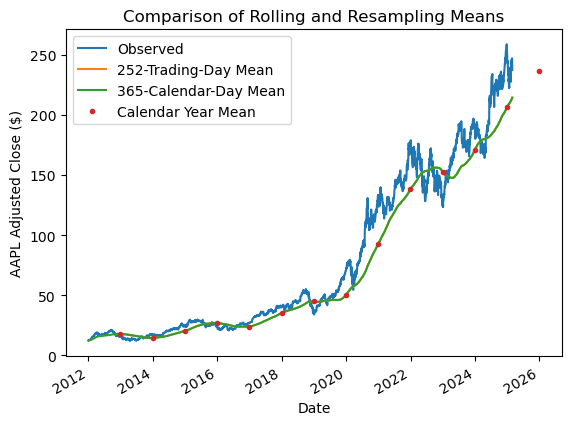

In [75]:
aapl = df.loc['2012':, ('Adj Close', 'AAPL')]
aapl.plot(label='Observed')
aapl.rolling(window=252).mean().plot(label='252-Trading-Day Mean') # min_periods defaults to 252
aapl.rolling(window='365D').mean().plot(label='365-Calendar-Day Mean') # min_periods defaults to 1
aapl.resample('YE').mean().plot(style='.', label='Calendar Year Mean')
plt.legend()
plt.ylabel('AAPL Adjusted Close ($)')
plt.title('Comparison of Rolling and Resampling Means')
plt.show()

::: {.callout-note}

If we specify the rolling window width as an integer:

1. Each rolling window is that many observations wide and ignores time stamps
2. Each rolling window must have that many non-missing observations 

We can specify `min_periods` to allow incomplete windows.
For integer window widths, `min_periods` defaults to the given integer window width.
For string date offsets, `min_periods` defaults to `1`.

:::

### Binary Moving Window Functions

Binary moving window functions accept two inputs.
The most common example is the rolling correlation between two return series.

In [76]:
returns = df['Adj Close'].pct_change()

In [77]:
returns

Ticker,AAPL,MSFT,SPY
Date,,,
1980-12-12,NaN,NaN,NaN
1980-12-15,-0.0522,NaN,NaN
1980-12-16,-0.0734,NaN,NaN
1980-12-17,0.0248,NaN,NaN
1980-12-18,0.0290,NaN,NaN
...,...,...,...
2025-02-21,-0.0011,-0.0190,-0.0171
2025-02-24,0.0063,-0.0103,-0.0046
2025-02-25,-0.0002,-0.0151,-0.0050


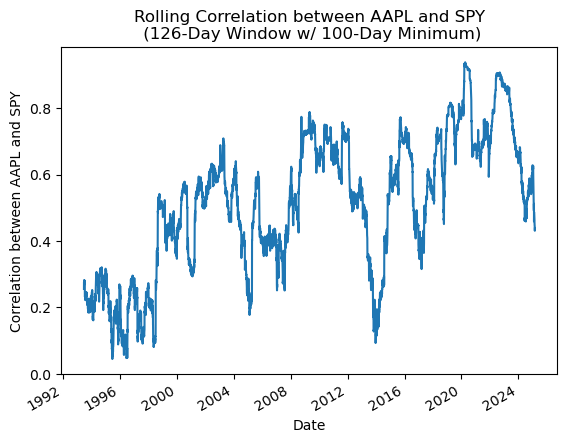

In [78]:
(
    returns['AAPL']
    .rolling(126, min_periods=100)
    .corr(returns['SPY'])
    .plot()
)
plt.ylabel('Correlation between AAPL and SPY')
plt.title('Rolling Correlation between AAPL and SPY\n (126-Day Window w/ 100-Day Minimum)')
plt.show()

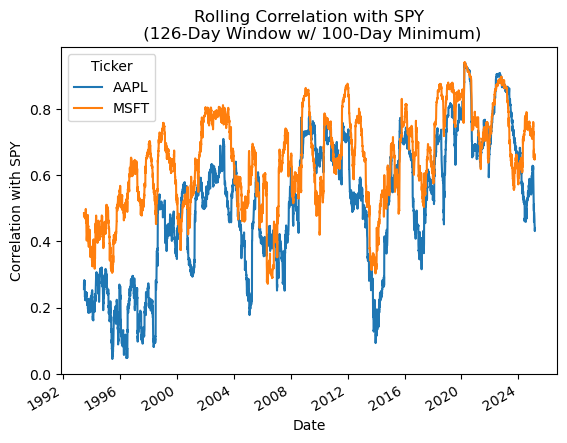

In [79]:
(
    returns[['AAPL', 'MSFT']]
    .rolling(126, min_periods=100)
    .corr(returns['SPY'])
    .plot()
)
plt.ylabel('Correlation with SPY')
plt.title('Rolling Correlation with SPY\n (126-Day Window w/ 100-Day Minimum)')
plt.show()

### User-Defined Moving Window Functions

We can define our own moving window functions and use them with the `.apply()` method.
However, note that `.apply()` method will be much slower than the optimized methods, like `.mean()` and `.std()`.
Here, we will calculate rolling volatility with `.apply()` and `.std()` and compare their speeds.

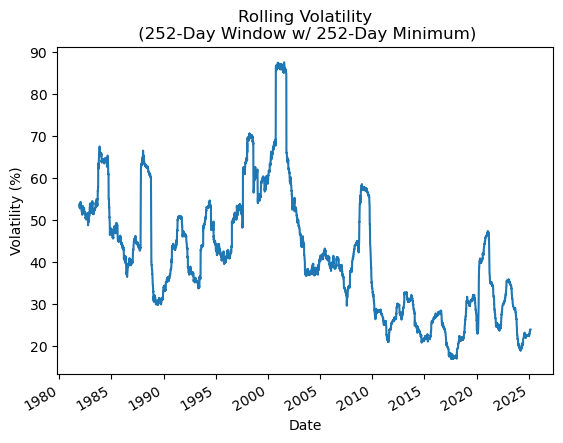

In [80]:
(
    returns['AAPL']
    .rolling(252)
    .apply(np.std)
    .mul(np.sqrt(252) * 100)
    .plot()
)
plt.ylabel('Volatility (%)')
plt.title('Rolling Volatility\n (252-Day Window w/ 252-Day Minimum)')
plt.show()

Do not be afraid to use `.apply()`, but realize that `.apply()` is often 1000 times slower than the optimized method!

In [81]:
%timeit returns['AAPL'].rolling(252).apply(np.std)

2.28 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit returns['AAPL'].rolling(252).std()

613 μs ± 80 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
